# Wrangle Data

## Project Details:

This project is from Udacity's Data Wrangling course, which is part of the Data Analyst Nanodegree program. The goal is practice data wrangling, i.e. to use Python and its libraries to gather data from various sources of different formats, assess its quality and tidiness, and then clean this data. Additionally, we will analyze and report on our findings. These efforts will be documented in this Jupyter Notebook.

The steps include:

- Gathering data
- Assessing this data
- Cleaning it
- Storing, analyzing, and visualizing the wrangled data
- Reporting on:
    1. Data wrangling efforts
    2. Data analyses and visualizations

*Please note some of the descriptive text in this notebook has been taken directly from the Udacity course materials. In particular, the indented sections are specific instructions for the project.*

## Table of Contents

- [Introduction](#intro)
- [Part I: Gathering Data](#gather)
- [Part II: Assessing Data](#assess)
    - [(1) Twitter Archive Data](#assess_archive)
    - [(2) Image Predictions](#assess_predictions)
    - [(3) API data](#assess_api)
    - [Assesment Summary: Issues List](#assess_summary)
- [Part III: Cleaning Data](#clean)
    - [(1) Missing Data](#clean_missing)
    - [(2) Tidiness](#clean_tidiness)
    - [(3) Quality](#clean_quality)
- [Part IV: Storing, Analyzing and Visualizing Data](#analyze)
    - [(1) Store Data](#analyze_store)
    - [(2) Analyze and Visualize Data](#analyze_analyze)
- [Conclusion](#concl)

<a id='intro'></a>
## Introduction

We will download a twitter archive and supplement it with additional data. As per to the Udacity course materials:

> The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

> WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

<a id='gather'></a>
## Part I: Gathering Data

The twitter archive contains basic data for over 5000 WeRateDogs tweets. We will gather data from two additional sources in order to make our analysis more interesting. Specifically, we will need:

1. The WeRateDogs Twitter archive (twitter_archive_enhanced.csv). This file has already been placed in the same directory as this notebook.

2. Tweet image predictions that have been created with a neural network image classifier and are accessible as part of the Udacity course materials.

3. Additional information gathered by using the Twitter API, such as like and retweet counts.

Let's start by importing some necessary Python libraries for our work.

In [1]:
#Import the necessary libraries needed for the project.

# Data analysis libraries
import pandas as pd
import numpy as np

# Visualizaton tools 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Networking libraries
import requests
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer

# For parsing json
import json

In [2]:
# Since our data will contain long strings, make sure we display entire strings of dataframe
pd.set_option('display.max_colwidth', -1)

<ipython-input-2-0481607fbd9a>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Let's load the WeRateDogs twitter archive into a Pandas dataframe.

In [3]:
# Create dataframe of WeRateDogs twitter archive and view the first few records.
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


Next we will gather the tweet image predictions, i.e., what is the dog's breed, etc. 

> Every image in the WeRateDogs Twitter archive has been run through a neural network that can classify breeds of dogs. The results include a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [4]:
# Set the url to the file's location
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# Request the url and save the response
response = requests.get(url)

# If there is not an error, write the file to our directory
if response.status_code == 200:
    with open('image_predictions.tsv', 'wb') as file:
        file.write(response.content)

In [5]:
# Load the predictions into a Pandas dataframe.
df_image_predictions =  pd.read_csv('image_predictions.tsv', sep='\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Because the archive doesn't contain important information such as retweet and favorite (like) counts, we will need to get these from Twitter's API.

> Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt. Each tweet's JSON data should be written to its own line. 

*Note: The student was unable to obtain API access from Twitter, therefore, as per the course instructions, the following code from the Udacity course materials has been cut and pasted into this notebook. It has been commented out, as running it would produce errors without the proper keys. If you wish to run it, you will need to insert your own consumer key and secret, as well as your own access token and secret and then uncomment all of the code. The tweet_json.txt file that would have been produced by running this code has been taken from the provided course materials and uploaded into the same directory as this notebook in order to simulate the final result of running this code.*

In [6]:
'''
# Keys, secrets, etc. are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

'\n# Keys, secrets, etc. are hidden to comply with Twitter\'s API terms and conditions\nconsumer_key = \'HIDDEN\'\nconsumer_secret = \'HIDDEN\'\naccess_token = \'HIDDEN\'\naccess_secret = \'HIDDEN\'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n\n# NOTE TO REVIEWER: this student had mobile verification issues so the following\n# Twitter API code was sent to this student from a Udacity instructor\n\n# Tweet IDs for which to gather additional data via Twitter\'s API\ntweet_ids = df_twitter_archive.tweet_id.values\nlen(tweet_ids)\n\n# Query Twitter\'s API for JSON data for each tweet ID in the Twitter archive\ncount = 0\nfails_dict = {}\nstart = timer()\n# Save each tweet\'s returned JSON as a new line in a .txt file\nwith open(\'tweet_json.txt\', \'w\') as outfile:\n    # This loop will likely take 20-30 minutes to run because of Twitter\'s rate limit\n    for tweet_id in tweet

Next, we need to read this the text file that was created above line by line into a pandas DataFrame, saving the tweet ID, retweet count, and favorite count.

*Again, note that tweet_json.txt file that would have been produced by the above code has been taken from the provided course materials and uploaded into the same directory as this notebook*

In [7]:
# Create our empty pandas dataframe (with column names only)
df_twitter_api_data = pd.DataFrame(columns = ['tweet_id', 'retweet_count', 'favorite_count'])

with open('tweet_json.txt', 'r') as file:

    # Read first line of tweet data
    tweet = file.readline()

    # Loop through successive tweets until no more left
    while (tweet):
        
        # Load json tweet data
        tweet_data = json.loads(tweet)

        # Extract and append the tweet data to our dataframe
        df_twitter_api_data = df_twitter_api_data.append({'tweet_id': tweet_data['id'], 
                          'retweet_count': tweet_data['retweet_count'], 
                          'favorite_count': tweet_data['favorite_count']
                         }, ignore_index=True)

        # Read in next tweet before going through the loop again
        tweet = file.readline()

# Print out the first few records of our dataframe
df_twitter_api_data.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


<a id='assess'></a>
## Part II: Assessing Data

Now that we have gathered our data, we must assess it visually and programmatically to identify any quality and tidiness issues. Our work must meet the following project standards:

- Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset. 
- We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
- Cleaning includes merging individual pieces of data according to the rules of tidy data.
- The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
- We do not need to gather the tweets beyond August 1st, 2017. Note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

Let's analyze each dataframe at a time starting with the archive. Then, all documented issues found will be summarized in a issues list section below.

<a id='assess_archive'></a>
### (1) Twitter Archive Data

We'll start by printing our dataframe and doing a quick visual assessment.

In [8]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


There are a number of issues that we can see right away:

1. The `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` columns all appear to contain many null (NaN) values. If a value is present in any of these columns, it indicates that the tweet is actually a reply (the first two) or a retweet (the last three). Because one of our requirements is that "we only want original ratings (no retweets)", we should remove any rows that have non-null values in any of these columns. Aftward, we can drop these columns, as they won't contain any values and they will only clutter our dataset.

2. The `source` column appears to be more wordy than it needs to be, i.e. do we actually need the hyperlink since it appears that this column is chiefly about identifying how the tweet was sent, i.e. from an iphone, the website or via another app?

3. The `text` column is actually a concatination of the tweet text, followed by the dog's rating, then a shortened hyperlink to the actual tweet itself on twitter. The rating has been split into the `rating_numerator` and `rating_denominator` columns. The full hyperlink has been expanded in the `expanded_urls` column. We could extract just the text part to isolate it and make it tidy, but unless we need this later in our analysis, this doesn't appear necessary at this time.

4. Sometimes the `expanded_urls` column contains more than one URL and scanning through them visually, they always appear to be duplicates. After opening up these URLs in a browser, it seems like there are duplicates when there is more than 1 photo in the tweet. However, these are not the URLs for the images, they are links to the original tweet itself. Unless we are going to be doing analysis on this column, fixing this issue doesn't seem to be a priority.

5. The `rating_denominator` column has at least one value that is not 10. Recall that ratings are supposed to be some number "out of 10."

6. The `name` column doesn't always contain a name. For example, there are words like "a" and "such" indicating that the extraction of the dog's name from the tweet text was not perfect. Also, there are "None" values.

7. The `doggo`, `floofer`, `pupper`, and `puppo` columns contain many "None" values. If the value is not "None", then it is simply a repeat of the column name. Also, it appears that either all of these columns within a given row are "None," or if not, then there is at most one of the four that is not "None." This is very untidy. These columns represent WeRateDog's unique  "dog stages" (i.e. what stage of life a dog is in). Since these columns all ultimately represent one variable, they should be merged into one `dog_stage` column.


Next, let's explore some of the columns programatically to better understand the issues at hand.

Let's inspect `source` column's values to determine how we should handle this column.

In [9]:
df_twitter_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

The `source` column has only a few values and they appear to represent the name of the app that was used to create the tweet, i.e. Twitter for iPhone, Vine, the Twitter Web Client (i.e. twitter.com in a browser), and TweetDeck. We clean it up by replacing the link with the actual app name.

Next, let's see if we can better understand the problem in the `name` column and understand why names were extracted incorrectly.

In [10]:
df_twitter_archive['name'].value_counts()

None        745
a           55 
Charlie     12 
Cooper      11 
Lucy        11 
            .. 
Thor        1  
Barclay     1  
Eugene      1  
Ralphson    1  
Emma        1  
Name: name, Length: 957, dtype: int64

So, it appears that in addition to "None," very common English words like "a", "the", "an", "very", etc. were extracted.

Let's look at this a little further by checking the values of all names that start with a lower case letter.

In [11]:
df_twitter_archive[df_twitter_archive['name'].str.get(0).str.islower()]['name'].value_counts()

a               55
the             8 
an              7 
very            5 
quite           4 
just            4 
one             4 
not             2 
actually        2 
mad             2 
getting         2 
such            1 
space           1 
all             1 
incredibly      1 
officially      1 
his             1 
light           1 
life            1 
my              1 
unacceptable    1 
old             1 
infuriating     1 
this            1 
by              1 
Name: name, dtype: int64

There's actually not many of these, so we could replace these with nulls. Did any of the more popular of these ("a", "the" or "an") appear at the beginning of a sentence, i.e. where they would presumably be capitalized.

In [12]:
df_twitter_archive[(df_twitter_archive['name'] == 'A') | (df_twitter_archive['name'] == 'The') 
                   | (df_twitter_archive['name'] == 'An')]['name'].count()

0

These non-names appear to have been extracted mid-sentence. Let's do a quick check on capitalized names to see if we see any other instances of issues that stand out.

In [13]:
df_twitter_archive[df_twitter_archive['name'].str.get(0).str.isupper()]['name'].value_counts()

None       745
Charlie    12 
Oliver     11 
Cooper     11 
Lucy       11 
           .. 
Kloey      1  
Aubie      1  
Thor       1  
Barclay    1  
Emma       1  
Name: name, Length: 932, dtype: int64

It looks like we can concentrate our efforts on fixing the list of uncapitalized words and "None" to clean this column.

Next, let's look at the `rating_denominator` column. As we saw above, dog ratings are generally on scale of some number "/10". Let's examine this more closely to see if we can determine how the ratings were extracted incorrectly from the `text` column.

In [14]:
df_twitter_archive[df_twitter_archive['rating_denominator'] != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


It appears that we run into problems when certain strings that look like ratings (i.e. "960/00") appear before the actual rating:  For example, when a date occurs before the rating (i.e. "4/20" for April 20) or when a percentage is given (i.e. 3 1/2). Sometimes, however, a rating is given for a group of dogs (i.e. 44/40) and in these cases it seems OK that we don't have the standard format of "/10."

Scanning through the list it appears there are less than 10 that are actually wrong and they can be fixed manually.

Next, let's examine the four columns that represent dog stages a little more closely (i.e. `doggo`, `floofer`, `pupper`, and `puppo`). From our initial visual assessment, it appeared that all four columns within a given row are "None" or at most one of them is has a different value. But is this actually true?

In [15]:
# Let's create a temporary dataframe that contains only rows that have at least one non-"None" value
check_dup_stages = df_twitter_archive[(df_twitter_archive['doggo']!='None') |
                  (df_twitter_archive['floofer']!='None') |
                  (df_twitter_archive['pupper']!='None') |
                   (df_twitter_archive['puppo']!='None')][['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']]

In [16]:
# Next, in order to be able to sum the number of non-None values per row, let's map
# them to numeric values. 0 for "None" and 1 for each of the column names
check_dup_stages.doggo = check_dup_stages.doggo.map({'None':0, 'doggo':1})
check_dup_stages.floofer = check_dup_stages.floofer.map({'None':0, 'floofer':1})
check_dup_stages.pupper = check_dup_stages.pupper.map({'None':0, 'pupper':1})
check_dup_stages.puppo = check_dup_stages.puppo.map({'None':0, 'puppo':1})

In [17]:
# Let's sum up our rows
check_dup_stages['stages_sum'] = check_dup_stages.doggo + check_dup_stages.floofer \
                                + check_dup_stages.pupper + check_dup_stages.puppo

In [18]:
check_dup_stages['stages_sum'].value_counts()

1    366
2    14 
Name: stages_sum, dtype: int64

It does appear that we have some rows that contain more than one dog stage. Given that there are at most 14 of them (depending on whether or not they are a reply, retween etc.), it seems that for the purpose of this analysis we can simply pick one of them when we merge these columns into a single column. Let's just verify that the only values that each of the 4 columns contains is None and a repeat of the name of that column itself.

In [19]:
df_twitter_archive['doggo'].value_counts()

None     2259
doggo    97  
Name: doggo, dtype: int64

In [20]:
df_twitter_archive['floofer'].value_counts()

None       2346
floofer    10  
Name: floofer, dtype: int64

In [21]:
df_twitter_archive['pupper'].value_counts()

None      2099
pupper    257 
Name: pupper, dtype: int64

In [22]:
df_twitter_archive['puppo'].value_counts()

None     2326
puppo    30  
Name: puppo, dtype: int64

Now that we've examined the columns that we know have issues, let's look examine our dataframe structure as a whole so we can investigate issues such as null counts and data types a little more closely.

In [23]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

The timestamp is being stored as a string. This should be changed to datetime type.

Besides the columns for replies, retweets and stages mentioned above. It looks like the `expanded_urls` column also contains null values. Let's examine when this occurs.

In [24]:
df_twitter_archive[df_twitter_archive['expanded_urls'].isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


All but four of these instances of null values are actually replies and one of those four is actually a retweet. Therefore, most of these rows will be removed from our set anyway. Let's look at the remaining three:

In [25]:
df_twitter_archive[(df_twitter_archive['tweet_id'] == 828361771580813312) 
                   | (df_twitter_archive['tweet_id'] == 785515384317313025) 
                   | (df_twitter_archive['tweet_id'] == 696518437233913856)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Beebop and Doobert should start a band 12/10 would listen,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


The issue appears to be that these three are missing the URL at the end of the text field, hence it can't be extracted into the `expanded_urls column`. If we plug the tweet id's into the twitter url format (for example, https://twitter.com/dog_rates/status/696518437233913856) and visit each of them in a browser, we can see that these tweets don't have photos. In order to follow our project's requirements, we will need to exclude these three rows.

Finally, let's verify that our dataset doesn't contain duplicates.

In [26]:
print('Duplicates: {}'.format(sum(df_twitter_archive.duplicated())))

Duplicates: 0


That wraps up our initial assement of the archive data!

<a id='assess_predictions'></a>
### (2) Image Predictions

As per the Udacity project description, the image predictions file is:
> a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).
> So for the last row in that table:
> - tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
- p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
- p1_conf is how confident the algorithm is in its #1 prediction → 95%
- p1_dog is whether or not the #1 prediction is a breed of dog → TRUE
- p2 is the algorithm's second most likely prediction → Labrador retriever
- p2_conf is how confident the algorithm is in its #2 prediction → 1%
- p2_dog is whether or not the #2 prediction is a breed of dog → TRUE
- etc.

Again, we'll start our assesment by printing our dataframe and doing a quick visual assessment.

In [27]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


The first thing that jumps out is that the values `p1`, `p2` and `p3` columns are dirty. There is inconsistent capitalization and underscores between words. We will need to clean these columns.

At a first glance all values appear to be present. However, we'll need to verify programatically later if nulls are present.

Another thing that stands out is `jpg_url` column. This contains a link to each dog photo in Twitter's image hosting domain. Since tweets can contain up to four images, we should dertermine if tweet id's are repeated:

In [28]:
sum(df_image_predictions['tweet_id'].duplicated())

0

There are no duplicate tweet id's, which will make it easier to merge this dataset with the archive, if necessary.

Next, let's confirm that there are no nulls and verify that our data types are correct.

In [29]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Our dataset contains no nulls and the data types for each column appear to be correct.

One thing that stands out, however, is that we have substantially fewer rows in this dataset than in the archive. Let's compare actual counts.

In [30]:
print('Rows in df_twitter_archive: {}'.format(df_twitter_archive.shape[0]))
print('Rows in df_image_predictions: {}'.format(df_image_predictions.shape[0]))

Rows in df_twitter_archive: 2356
Rows in df_image_predictions: 2075


Recall that we will need to remove some rows from the archive because they are replies or retweets. There were also 3 regular tweets that do not contain images that we will need to remove. Let's get a total count of the archive rows that will remain and compare it to our image prediction row size.

In [31]:
print('Replies to remove: {}'.format(df_twitter_archive[~df_twitter_archive['in_reply_to_status_id'].isna()].tweet_id.count()))
print('Retweets to remove: {}'.format(df_twitter_archive[~df_twitter_archive['retweeted_status_id'].isna()].tweet_id.count()))

Replies to remove: 78
Retweets to remove: 181


So, we already know we will be exlcuding 262 records (3 + 78 + 181), which leaves us with a total of about 2094 df_twitter_archive rows, which is still higher than the 2075 image predictions.

Bottom line: There are about 19 tweets in the archive for which we will not have image predictions.

This brings us to our last point. From a tidiness standpoint, while we there is a case to be made to store this information in it's own separate dataframe/table, it will facilitate our analysis if it is moved into the same dataframe as our archive data.

<a id='assess_api'></a>
### (3) API data

In [32]:
df_twitter_api_data

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


There are no glaring issues that are visible when scrolling through the dataset. Let's check for nulls and mismatched datatypes programatically.

In [33]:
df_twitter_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   object
 2   favorite_count  2354 non-null   object
dtypes: object(3)
memory usage: 55.3+ KB


There are no nulls, however all of our columns are numbers (specifically, integers), yet they are being stored as text. Retweet_count and favorite_count should be changed to integer types, as we will want to be able to perform numeric and statistical funtions on them. Initially, it might not seem necessary to convert the tweet_id column, as we will not be performing mathematical functions on it, however if we wish to join our data with the archive data (where tweet_id is an integer), our column should be of the same type.

Next let's check to see if there are any duplicates.

In [34]:
print('Duplicates: {}'.format(sum(df_twitter_api_data.duplicated())))

Duplicates: 0


Note, however, that there are only 2354 rows in the api data, but there are 2356 rows in our archive. While we will be removing replies, retweets and tweets without photos, it is possible that there could be some missing data.

Finally, from a tidiness perspective, there is no reason this data needs to be in its own separate dataframe. In fact, it should be merged into the larger twitter archive dataframe as retweet and favorite counts are essential to a tweet.

<a id='assess_summary'></a>
### Assesment Summary: Issues List

Below is a list of our identified quality and tidiness issues for all dataframes that we will need to clean.

#### Quality

##### `df_twitter_achive` dataframe
- Replies and retweets are included (i.e. there are non-nulls in the `in_reply_to_status_id`, `in_reply_to_user_id`, `in retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` columns.)
- Some tweets have no photo (i.e. the `expanded_urls` column contains nulls.)
- `name` contains erroneous values ("a", "such", "None")
-  `rating_numerator` and `rating_denominator` were not always extracted correctly, especially if there was a date or percentage preceding the rating in the tweet.
- `source` column contains unnecessary link information. We can strip it and just keep the actual app name.
- `timestamp` has the wrong data type (it should be datetime and not text)


##### `df_image_predictions` dataframe
- The `p1`, `p2` and `p3` columns are dirty (i.e. capitalization is inconsistent and there are underscores between words.)
- Not all tweets in the archive have an image prediction. There are 2075 image predictions and 2356 tweets in the archive. Even after we remove replies, retweets and tweets without photos there will still be 2094 tweets in the archive.

##### `df_twitter_api_data` dataframe
- `tweet_id`, `retweet_count` and `favorite_count` should be converted to integer format (to be consistent with our other dataframes.)
- Not all tweets in the archive have associated api data. There are only 2354 rows in the api data, but there are 2356 rows in our archive.

#### Tidiness

##### `df_twitter_achive` dataframe
- The `doggo`, `floofer`, `pupper`, and `puppo` columns all represent a single idea and should be converted into a single `dog_stage` column.
- After removing the non-nulls in `in_reply_to_status_id`, `in_reply_to_user_id`, `in retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`, we should remove these columns as they clutter our dataset.

##### `df_image_predictions` dataframe
- This dataset should be merged into the larger tweet archive, joined on `tweet_id`

##### `df_twitter_api_data` dataframe
- The `retweet_count` and `favorite_count` columns should be merged into the larger tweet archive, joined on `tweet_id` (which needs to be converted to an integer type first)



<a id='clean'></a>
## Part III: Cleaning Data

> Clean each of the issues you documented while assessing. The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

The first thing that need to do copy our datasets to a new frames before we start cleaning them.

In [35]:
df_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_api_data_clean = df_twitter_api_data.copy()

Next, we'll adress the issues above in an organized fashion. We will start by handling issues with missing data. Then, we will address our tidiness issues. Finally, we will fix the quality issues.

<a id='clean_missing'></a>
### (1) Missing Data

#### Issue: Replies and retweets are included in our archive dataset.

##### Define
Keep only rows that contain null values in the `in_reply_to_status_id` and `in retweeted_status_id` columns. This will "delete" all of the replies and retweets respectively.

##### Code

In [36]:
# Remove all replies
df_archive_clean = df_archive_clean[df_archive_clean['in_reply_to_status_id'].isnull()]

In [37]:
# Remove all retweets
df_archive_clean = df_archive_clean[df_archive_clean['retweeted_status_id'].isnull()]

##### Test

In [38]:
# Verify that there are no non-null values in the 'in_reply_to_status_id' or 'in_reply_to_user_id' columns
# As these are the two columns associated with replies, we should see '0' returned
df_archive_clean[(~df_archive_clean['in_reply_to_status_id'].isnull()) | (~df_archive_clean['in_reply_to_user_id'].isnull())]['tweet_id'].count()

0

In [39]:
# Verify that there are no non-null values in the in 'retweeted_status_id', 'retweeted_status_user_id', 
# or 'retweeted_status_timestamp' columns
# As these are the two columns associated with retweets, we should see '0' returned
df_archive_clean[(~df_archive_clean['retweeted_status_id'].isnull()) | (~df_archive_clean['retweeted_status_user_id'].isnull()) | (~df_archive_clean['retweeted_status_timestamp'].isnull())]['tweet_id'].count()

0

#### Issue: Tweets have no photo are included in our archive dataset.

##### Define
Remove rows that have nulls in the `expanded_urls` column.

##### Code

In [40]:
# Remove rows with null in 'expanded_urls' column
df_archive_clean = df_archive_clean[~df_archive_clean['expanded_urls'].isnull()]

##### Test

In [41]:
# Verify that the number of rows with null in 'expanded_urls' column is 0
df_archive_clean[df_archive_clean['expanded_urls'].isnull()]['tweet_id'].count()

0

In [42]:
# Let's do a quick count on the number of remaining rows in the archive. It should be 2094, as calculated in the 
# Assess section
df_archive_clean.shape[0]

2094

#### Issue: Not all tweets in the archive have an image prediction.

There are 2075 image predictions and 2356 tweets in the archive. Even after we remove replies, retweets and tweets without photos there will still be 2094 tweets in the archive. There will be at most 19 tweets that don't have associated image predictions. It seems safe to be able to exclude these from our analysis. If we perform an inner join when merging the image predictions into the archive dataset, this issue will be addressed as a result. There's no action required at this time.

#### Issue: Not all tweets in the archive have associated api data. 

There are only 2354 rows in the api data, but there are 2356 rows in our archive. There will be at most 2 tweets that don't have associated api data. It seems safe to be able to exclude these from our analysis. If we perform an inner join when merging the api data into the archive dataset, this issue will be addressed as a result. There's no action required at this time.

<a id='clean_tidiness'></a>
### (2) Tidiness

#### Issue: The columns associated with replies and retweets should be removed from the twitter archive.

##### Define

Drop the `in_reply_to_status_id`, `in_reply_to_user_id`, `in retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` columns from `df_archive_clean`.

##### Code

In [43]:
# Drop the columns and save the result
df_archive_clean = df_archive_clean.drop(['in_reply_to_status_id', 
                                          'in_reply_to_user_id', 
                                          'retweeted_status_id', 
                                          'retweeted_status_user_id', 
                                          'retweeted_status_timestamp'], axis=1)

##### Test

In [44]:
# Verify that the above columns are not present in the list of returned columns
df_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

#### Issue: The `doggo`, `floofer`, `pupper`, and `puppo` columns of the image predictions dataset should be converted into a single `dog_stage` column.

##### Define

Merging columns just screams for using the pandas ["melt" function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html). We pick our set of columns to be used as the "id" for each row (this will be all of the columns that we're not merging or "melting" together), as well as the four that we are melting together (these are the "values"). This will reduce our four columns down to two: one for the original column name (the "variable") and one for it its "value." Note that in our case this will create four rows for each tweet id. We don't need the "variable" column, so we can drop that. Now, if only we could we could easily pick the one of these four rows that we need to keep. Fortunately, the Panda's sort_values function can help. Becuase it will sort capitalized words before uncapitalized ones, we will easily be able to identify a non-"None" value if one exists, as it will be the last one after sorting. Then all we need to do is to drop the preceding rows. As we saw in the Assess section above, there is the rare case where there is actually more than one dog stage. In this case we will chose the one that gets sorted to the last position.

To summarize, in order to "melt" the above four columns into a single `dog_stages` column, we will have to perform the following steps:
1. Prepare the parameters we need in order to use the Panda's melt command.
2. Perform the actual melt.
3. Delete the unneeded "variable" column.
4. Sort our resulting dataframe by `dog_stage`, causing rows with a "None" stage to float to the top.
5. Drop the "duplicate" rows for each tweet_id, keeping only the one the last sorted `dog_stage` "value."

##### Code

Before we begin, lets get a count of how many of our tweets contain a value in one of the 4 columns named above. This number should match the number of records that have a value in the newly created `dog_stage` column when we are done.

In [45]:
# Get count of columns with at least one dog stage
df_archive_clean[(df_archive_clean['doggo']!='None') |
                  (df_archive_clean['floofer']!='None') |
                  (df_archive_clean['pupper']!='None') |
                   (df_archive_clean['puppo']!='None')].tweet_id.count()

335

In [46]:
# Columns used for id_vars parameter in the melt will be all but the last 4 in our archive
id_cols = df_archive_clean.columns[:-4].values.tolist()
id_cols

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name']

In [47]:
# Columns used in the value_vars parameter in melt will be the last 4 in our archive 
# (i.e. doggo, floofer, pupper, and puppo)
value_cols = df_archive_clean.columns[8:].values.tolist()
value_cols

['doggo', 'floofer', 'pupper', 'puppo']

In [48]:
# Perform the melt. This will create a row for each tweet for each of the columns specified in the value_vars
# The "value" of that original column will be placed in the "dog_stage" column (specified in the value_name paramenter)
df_archive_clean = pd.melt(df_archive_clean, id_vars = id_cols, value_vars = value_cols, value_name='dog_stage')

In [49]:
# We won't need the variable column, so let's drop it
df_archive_clean = df_archive_clean.drop(['variable'], axis=1)

In [50]:
# Sort on the tweet_id and dog_stage column
df_archive_clean = df_archive_clean.sort_values(by=['dog_stage'])

In [51]:
# Let's drop the unnecessary rows for each tweet id (our subset), use keep='last' to make sure
# that any non-None values are chosen.
df_archive_clean = df_archive_clean.drop_duplicates(subset='tweet_id', keep='last')

##### Test

In [52]:
# Verify that we haven't lost any rows. This should return 2094.
df_archive_clean.shape[0]

2094

In [53]:
# Verify that we have the same number of rows that contain a non-None dog_stage value that we did above,
# i.e. this should return 335.
df_archive_clean[df_archive_clean['dog_stage']!='None'].tweet_id.count()

335

#### Issue: The image predictions dataset should be merged into the larger tweet archive, joined on `tweet_id`

##### Define

- Determine the total number of rows that should result from the merge so that we can test our result
- Merge `df_image_predictions_clean` into `df_archive_clean` with a left join on `tweet_id`

##### Code

In [54]:
# Create a set of the tweet ids in our archive
archive_tweet_ids = set(df_archive_clean['tweet_id'].tolist())

# Create a set of the tweet ids in our image predictions
prediction_tweet_ids = set(df_image_predictions_clean['tweet_id'].tolist())

# Get the set of ids that are in the archive that are not in the image predictions file
missing_tweet_ids = archive_tweet_ids.difference(prediction_tweet_ids)

# Print the total number of id's that will be present in our merged sets
len(archive_tweet_ids) - len(missing_tweet_ids)

1971

In [55]:
# Merge the two dataframes
df_archive_clean = df_archive_clean.merge(df_image_predictions_clean, how='inner', on='tweet_id') 

##### Test

In [56]:
# Verify visually that the newly merged data is present
# Specifically that the jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, and p3_dog columns are present
df_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,None,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1,Rottweiler,0.999091,True,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True
1,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,None,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1,porcupine,0.989154,False,bath_towel,0.006300,False,badger,0.000966,False
2,667443425659232256,2015-11-19 20:44:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6,10,None,None,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,1,goose,0.980815,False,drake,0.006918,False,hen,0.005255,False
3,667453023279554560,2015-11-19 21:22:56 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11,10,Cupcake,None,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1,Labrador_retriever,0.825670,True,French_bulldog,0.056639,True,Staffordshire_bullterrier,0.054018,True
4,667455448082227200,2015-11-19 21:32:34 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,https://twitter.com/dog_rates/status/667455448082227200/photo/1,7,10,Reese,None,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,1,Tibetan_terrier,0.676376,True,Irish_terrier,0.054933,True,Yorkshire_terrier,0.040576,True


In [57]:
# The total number of rows in the archive should now match what we calculated above
df_archive_clean.shape[0]

1971

#### Issue: The api data should be merged into the larger tweet archive, joined on `tweet_id` (which needs to be converted to an integer type first)

##### Define

- Convert the `tweet_id` column of `df_api_data_clean` to an integer
- Determine the total number of rows that should result from the merge so that we can test our result
- Merge `df_api_data_clean` into `df_archive_clean` with a left join on `tweet_id``

##### Code

In [58]:
# Convert the tweet_id column of the api data to an integer
df_api_data_clean['tweet_id'] = df_api_data_clean['tweet_id'].astype(int)

In [59]:
# Create a set of the tweet ids in our archive
archive_tweet_ids = set(df_archive_clean['tweet_id'].tolist())

# Create a set of the tweet ids in our api data
api_tweet_ids = set(df_api_data_clean['tweet_id'].tolist())

# Get the set of ids that are in the archive that are not in the image predictions file
missing_tweet_ids = archive_tweet_ids.difference(api_tweet_ids)

# Print the total number of id's that will be present in our merged sets
len(archive_tweet_ids) - len(missing_tweet_ids)

1971

In [60]:
# Merge the two dataframes
df_archive_clean = df_archive_clean.merge(df_api_data_clean, how='inner', on='tweet_id')

##### Test

In [61]:
# Verify that the newly merged data is present, specifically the retweet_count and favorite_count columns
df_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,None,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,...,0.999091,True,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True,89,326
1,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,None,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,...,0.989154,False,bath_towel,0.006300,False,badger,0.000966,False,257,483
2,667443425659232256,2015-11-19 20:44:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6,10,None,None,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,...,0.980815,False,drake,0.006918,False,hen,0.005255,False,620,833
3,667453023279554560,2015-11-19 21:22:56 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11,10,Cupcake,None,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,...,0.825670,True,French_bulldog,0.056639,True,Staffordshire_bullterrier,0.054018,True,96,327
4,667455448082227200,2015-11-19 21:32:34 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,https://twitter.com/dog_rates/status/667455448082227200/photo/1,7,10,Reese,None,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,...,0.676376,True,Irish_terrier,0.054933,True,Yorkshire_terrier,0.040576,True,66,203


In [62]:
# The total number of rows in the archive should be equal to the count tallied above
df_archive_clean.shape[0]

1971

<a id='clean_quality'></a>
### (3) Quality

#### Issue: `timestamp` has the wrong data type (it should be datetime and not text)

##### Define

Convert the `timestamp`column to datetime type

##### Code

In [63]:
# Convert to datetime
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

##### Test

In [64]:
# Verify that timestamp has datetime data type
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   int64              
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   name                1971 non-null   object             
 8   dog_stage           1971 non-null   object             
 9   jpg_url             1971 non-null   object             
 10  img_num             1971 non-null   int64              
 11  p1                  1971 non-null   object             
 12  p1_conf             1971 non-null 

#### Issue: `retweet_count` and `favorite_count` should be converted to integer format 

##### Define

- Convert retweet_count to integer
- Convert favorite_count to integer

##### Code

In [65]:
# Convert datatypes to int
df_archive_clean['retweet_count'] = df_archive_clean['retweet_count'].astype(int)
df_archive_clean['favorite_count'] = df_archive_clean['favorite_count'].astype(int)

##### Test

In [66]:
# Verify that both columns are now of data type integer
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   int64              
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   name                1971 non-null   object             
 8   dog_stage           1971 non-null   object             
 9   jpg_url             1971 non-null   object             
 10  img_num             1971 non-null   int64              
 11  p1                  1971 non-null   object             
 12  p1_conf             1971 non-null 

#### Issue: `source` column contains unnecessary link information. We can strip it and just keep the actual app name.

##### Define

- Map the correct app name onto each of the corresponding hyperlinks that make up the four values that we identified for this column in the Assess section.

##### Code

In [67]:
# Clean the source column by mapping links to appropriate values
df_archive_clean['source'] = df_archive_clean['source'].map({'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':'Twitter for iPhone', 
                                                             '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':'Vine',
                                                            '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':'Twitter Web Client',
                                                            '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':'TweetDeck'})

##### Test

In [68]:
# Verify that the long hyperlinks have been replaced with the app names
df_archive_clean['source'].value_counts()

Twitter for iPhone    1932
Twitter Web Client    28  
TweetDeck             11  
Name: source, dtype: int64

#### Issue:  `name` contains erroneous values ("a", "such", "None")

##### Define

- Replace lower case words and "None" with np.nan (which is the standard, as per the [Pandas text documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html))

##### Code

In [69]:
# Get value counts in name column to demonstrate that "None" and lowercase words are present
df_archive_clean['name'].value_counts()

None       524
a          55 
Charlie    11 
Lucy       10 
Oliver     10 
           .. 
Tonks      1  
Bungalo    1  
Crumpet    1  
Jo         1  
Stefan     1  
Name: name, Length: 935, dtype: int64

In [70]:
# Get a list of all of the lower case words
names_to_clean = df_archive_clean[df_archive_clean['name'].str.get(0).str.islower()]['name'].value_counts().index.tolist()

# Append "None" to the list
names_to_clean.append('None')

# Replace all occurances of the words in the list to np.nan
df_archive_clean['name'].replace(names_to_clean, np.nan, inplace = True)

##### Test

In [71]:
# Get value counts in name column to demonstrate that "None" and lowercase words are no longer present
df_archive_clean['name'].value_counts()

Charlie      11
Lucy         10
Cooper       10
Oliver       10
Penny        9 
            .. 
Goliath      1 
Sprinkles    1 
Tonks        1 
Bungalo      1 
Stefan       1 
Name: name, Length: 912, dtype: int64

In [72]:
# Loop through the list of names we deemed for cleaning and see if it is found in the archive
# Should return false for each name in the list
for name in names_to_clean:
    print(name in df_archive_clean['name'])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


#### Issue:  `rating_numerator` and  `rating_denominator` were not always extracted correctly, especially if there was a date or percentage preceding the rating in the tweet.

##### Define

There were only a small amount of tweets in which the rating was incorrectly extracted. We can eyeball these and fix these manually:

- Determine which of the tweets that have ratings_demoninators that are greater than ten still remain in our cleaned set
- Determine which of the above need to be fixed manually
- Manually assign the correct rating for each of the tweets

##### Code

In [73]:
# Get a list of the tweets that have a rating with a denominator higher than 10.
df_archive_clean[df_archive_clean['rating_denominator'] != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
100,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2
265,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
310,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
314,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7,11
381,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
404,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
430,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
455,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
476,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
563,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50


We observe the following:

- The tweet at index 1331 has a photo, but not a rating. We should remove this tweet from our set.
- The tweets at the following indices have strings with a "/" and were parsed incorrectly and should have their numerators and denominators set as follows:
1. index: 100, rating_numerator: 9, rating_denominator: 10
2. index: 314, rating_numerator: 10, rating_denominator: 10
3. index: 455, rating_numerator: 13, rating_denominator: 10
4. index: 476, rating_numerator: 11, rating_denominator: 10
5. index: 1146, rating_numerator: 14, rating_denominator: 10

The others are ratings for multiple dogs so it's OK if the denominators are more than 10.

In [74]:
# Remove the tweet at index 1331
df_archive_clean = df_archive_clean.drop(df_archive_clean.index[1331])

In [75]:
# Correct the rating of the tweet with index 100
df_archive_clean.at[100, 'rating_numerator'] = 9
df_archive_clean.at[100, 'rating_denominator'] = 10

In [76]:
# Correct the rating of the tweet with index 314
df_archive_clean.at[314, 'rating_numerator'] = 10
df_archive_clean.at[314, 'rating_denominator'] = 10

In [77]:
# Correct the rating of the tweet with index 455
df_archive_clean.at[455, 'rating_numerator'] = 13
df_archive_clean.at[455, 'rating_denominator'] = 10

In [78]:
# Correct the rating of the tweet with index 476
df_archive_clean.at[476, 'rating_numerator'] = 11
df_archive_clean.at[476, 'rating_denominator'] = 10

In [79]:
# Correct the rating of the tweet with index 1146
df_archive_clean.at[1146, 'rating_numerator'] = 14
df_archive_clean.at[1146, 'rating_denominator'] = 10

##### Test

In [80]:
# Verify that the tweet with index 1331 is no longer in our archive
# By checking that it's not present between the range of indexes that precede and follow it
df_archive_clean.iloc[1330:1332]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1330,829501995190984704,2017-02-09 01:27:41+00:00,Twitter for iPhone,This is Leo. He was a skater pup. She said see ya later pup. He wasn't good enough for her. 12/10 you're good enough for me Leo https://t.co/Xw9JbJHTul,"https://twitter.com/dog_rates/status/829501995190984704/photo/1,https://twitter.com/dog_rates/status/829501995190984704/photo/1",12,10,Leo,None,https://pbs.twimg.com/media/C4L7p19W8AA3Fs_.jpg,...,0.950851,True,Pekinese,0.015200,True,pug,0.011094,True,12224,34913
1332,811627233043480576,2016-12-21 17:39:46+00:00,Twitter for iPhone,This is Augie. He's a savage. Doesn't give a h*ck about your garden. Still 10/10 would forgive then pet https://t.co/IU8S0n4oxn,https://twitter.com/dog_rates/status/811627233043480576/photo/1,10,10,Augie,None,https://pbs.twimg.com/media/C0N6opSXAAAkCtN.jpg,...,0.396280,True,Pembroke,0.049562,True,wire-haired_fox_terrier,0.046349,True,3650,14265


In [81]:
# Verify that the tweet at index 100 has the correct rating
# Should be 9/10
print(df_archive_clean.iloc[100]['rating_numerator'], df_archive_clean.iloc[100]['rating_denominator'], sep='/')

9/10


In [82]:
# Verify that the tweet at index 314 has the correct rating
# Should be 10/10
print(df_archive_clean.iloc[314]['rating_numerator'], df_archive_clean.iloc[314]['rating_denominator'], sep='/')

10/10


In [83]:
# Verify that the tweet at index 455 has the correct rating
# Should be 13/10
print(df_archive_clean.iloc[455]['rating_numerator'], df_archive_clean.iloc[455]['rating_denominator'], sep='/')

13/10


In [84]:
# Verify that the tweet at index 476 has the correct rating
# Should be 11/10
print(df_archive_clean.iloc[476]['rating_numerator'], df_archive_clean.iloc[476]['rating_denominator'], sep='/')

11/10


In [85]:
# Verify that the tweet at index 1146 has the correct rating
# Should be 14/10
print(df_archive_clean.iloc[1146]['rating_numerator'], df_archive_clean.iloc[1146]['rating_denominator'], sep='/')

14/10


#### Issue: The `p1`, `p2` and `p3` columns are dirty (i.e. capitalization is inconsistent and there are underscores between words.)

##### Define

- Remove underscores from the `p1`, `p2` and `p3` columns
- convert all strings in these columns to lowercase

##### Code

In [86]:
# Remove underscores from columns
df_archive_clean['p1'].replace('_', ' ', regex=True, inplace = True)
df_archive_clean['p2'].replace('_', ' ', regex=True, inplace = True)
df_archive_clean['p3'].replace('_', ' ', regex=True, inplace = True)

In [87]:
# Convert all p1, p2, p3 strings to lowercase
df_archive_clean['p1'] = df_archive_clean['p1'].str.lower()
df_archive_clean['p2'] = df_archive_clean['p2'].str.lower()
df_archive_clean['p3'] = df_archive_clean['p3'].str.lower()

##### Test

In [88]:
# Verify that underscores and uppercase no longer present in p1 values
df_archive_clean['p1'].value_counts()

golden retriever      136
labrador retriever    94 
pembroke              88 
chihuahua             78 
pug                   54 
                      .. 
stove                 1  
cash machine          1  
bakery                1  
bannister             1  
book jacket           1  
Name: p1, Length: 373, dtype: int64

In [89]:
# Verify that underscores and uppercase no longer present in p2 values
df_archive_clean['p2'].value_counts()

labrador retriever          95
golden retriever            82
cardigan                    73
chihuahua                   43
chesapeake bay retriever    40
                            ..
armadillo                   1 
windsor tie                 1 
affenpinscher               1 
tray                        1 
streetcar                   1 
Name: p2, Length: 396, dtype: int64

In [90]:
# Verify that underscores and uppercase no longer present in p3 values
df_archive_clean['p3'].value_counts()

labrador retriever    75
chihuahua             57
golden retriever      45
eskimo dog            36
kelpie                33
                      ..
golfcart              1 
stinkhorn             1 
red wolf              1 
balance beam          1 
common newt           1 
Name: p3, Length: 403, dtype: int64

We have finally resolved all of our identified issues and cleaned our data. Note that we may not have identified every single issue, however we have a much cleaner data set and we can always revisit this section to resolve any additional issues.

Let's save a final copy of our dataframe.

In [91]:
# Save a final clean copy of our dataframe
df_archive_final = df_archive_clean.copy()

<a id='analyze'></a>
## Part IV: Storing, Analyzing and Visualizing Data

Now that are data has been cleaned we should store it in a new file that can be used in future work. Next, we can start analyzing and visualizing our data to identify interesting trends.

<a id='analyze_store'></a>
### (1) Store Data

> Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. If additional files exist because multiple tables are required for tidiness, name these files appropriately.

In [92]:
# Store a copy of our final archive in a CSV file. No additional files are necessary.
df_archive_final.to_csv('twitter_archive_master.csv')

<a id='analyze_analyze'></a>
### (2) Analyze and Visualize Data

> Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least three (3) insights and one (1) visualization must be produced.

One thing that stuck out when we were cleaning the dog ratings, especially because the account is famous for its higher then 10/10 ratings, was that one of the ones that we cleaned was 9/10. We'll definately want to explore the ratings more. Also, given our image predictions and retweet and favorite data, it would be interesting to see if tweets about certain breeds got more user interaction or interest.

While there are a plethora of questions to investigate, we will explore the following questions in this analyis:

1. What is the average rating?
2. Have rating trends changed over time, i.e. are the ratings higher in later tweets vs. earlier tweets?
3. Do certain dog breeds have higher ratings?
4. Based on retweets and favorites, what dog breeds are the most popular?

#### Question (1): What is the average rating?

Given that we chose to keep rating denominators that were higher than 10 (i.e. multiple dogs were included in the same rating), there are a couple of ways we can procede to answer this question:
- We can get an average rating per dog by summing up all of our ratings numerators and then dividing by the sum of all of our ratings denominators.
- Alternatively, we can average all one dog ratings (i.e. get the average of all ratings that have a denominator of 10) and see how it compares to the above.

In [93]:
# Calculate average of all ratings in the set
ave_rating_all = sum(df_archive_final['rating_numerator'])/sum(df_archive_final['rating_denominator'])
# Format numerator for printing
ave_denominator = round(ave_rating_all * 10, 2)
print('Ave. rating per dog: {}/10'.format(ave_denominator))

Ave. rating per dog: 11.67/10


Converting this into a fraction, we have an average across all dogs of 11.67/10.

Let's look at just the one dog ratings next.

In [94]:
# Calculate the average one dog rating
ave_one_dog = round(df_archive_final[df_archive_final['rating_denominator'] == 10]['rating_numerator'].mean(), 2)
print('Ave. one dog rating: {}/10'.format(ave_one_dog))

Ave. one dog rating: 11.7/10


Interesting! When only a single dog is rated, the rating is actually slightly higher. *(Note that the rating is printed as "11.7" when it is actually 11.70.)*

Just out of curiosity, let's calculate the average per dog in tweets that contain a single rating with more than one dog.

In [95]:
# Get dataset of tweets with rating_denominator greater 10, i.e. more than one dog is being rated
df_multiple_dog_tweets = df_archive_final[df_archive_final['rating_denominator'] > 10]

# Get the average rating of this set
ave_mult_dog = sum(df_multiple_dog_tweets['rating_numerator'])/sum(df_multiple_dog_tweets['rating_denominator'])

# Format numerator for printing
ave_mult_dog_numerator = round(ave_mult_dog * 10, 2)
print('Ave. per dog in multi dog tweet: {}/10'.format(ave_mult_dog_numerator))

Ave. per dog in multi dog tweet: 11.19/10


This is actually quite a bit lower. Given that the difference between the average rating per dog and the average one dog rating was much smaller, it seems likely that there aren't many ratings in our set for multiple dogs at once. Let's get a count of them.

In [96]:
df_multiple_dog_tweets['tweet_id'].count()

12

So, we can see that there aren't many multiple dog ratings (12 in total) in the set. 

In general, we can safely say that our average rating is about 11.7/10

Finally, our analysis of ratings wouldn't be complete without looking for outliers and then plotting our distribution. First, let's check the range of our values.

In [97]:
# Create a distribution of all of our ratings normalized on a scale of 10
ave_ratings = (df_archive_final['rating_numerator']/df_archive_final['rating_denominator'] * 10).astype(int)
# Check value counts for the rating column
ave_ratings.value_counts()

12      449
10      419
11      398
13      254
9       151
8       96 
7       51 
14      34 
5       33 
6       32 
3       19 
4       15 
2       9  
1       4  
75      1  
420     1  
0       1  
27      1  
26      1  
1776    1  
dtype: int64

The values of 1776 and 420 look like they are one-offs to celebrate special occasions such as American independence and Earth Day. They only occur once. On the other end of the spectrum, there is a single 0 rating. 

Finally, let's plot our distribution. For now, we'll ignore our five rating outliers (26, 27, 75, 420, 1776) that occur only one time.

Text(0.5, 0, 'Rating')

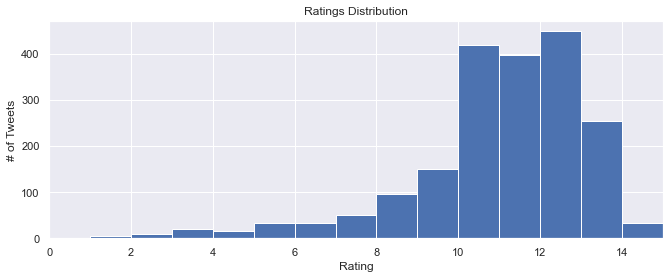

In [98]:
# Set graph size
sns.set(rc={'figure.figsize':(11, 4)})

# Plot the distribution
ax = ave_ratings.plot(kind='hist', title = 'Ratings Distribution', bins=np.arange(min(ave_ratings), max(ave_ratings) + 1, 1));
# Ignore outliers
ax.set_xlim(0, 15)
ax.set_ylabel("# of Tweets")
ax.set_xlabel("Rating")

As we can see, looking at the average rating per dog, our plot is left skewed and we have a small number of low ratings with a much larger number of those in the 11-13/10 range.

#### Question (2): Have rating trends changed over time?

Next, let's determine how ratings have evolved over time. Can we tell if our rater become more generous over time or are they more demanding?

Let's create a new dataframe that holds normalized ratings (i.e. all will be on a scale of 10, which means will take the average rating per dog for multiple dog ratings).

In [99]:
# Create a new dataframe with timestamp and rating (which is a normalized rating on a scale out of 10)
df_ratings = df_archive_final[['timestamp', 'rating_numerator', 'rating_denominator' ]]
df_ratings['rating'] = (df_ratings['rating_numerator']/df_ratings['rating_denominator'] * 10).astype(int)
# Drop columns that are no longer needed
df_ratings = df_ratings[['timestamp','rating']]
df_ratings.set_index('timestamp');

<ipython-input-99-ecc4e7e53d96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating'] = (df_ratings['rating_numerator']/df_ratings['rating_denominator'] * 10).astype(int)


Let's take a preliminary look at our ratings trends over time.

Text(0, 0.5, 'Rating (out of 10)')

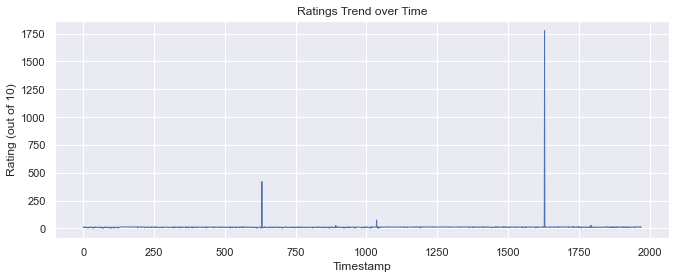

In [100]:
# Preliminary plot
ax = df_ratings['rating'].plot(title='Ratings Trend over Time', linewidth=1);
ax.set_xlabel("Timestamp")
ax.set_ylabel("Rating (out of 10)")

Yikes! First, plotting our results by each timestamp gives us resuts that are way too fine/precise. We should take an average per month. 

More importantly, we've got those outliers we saw above. Since we are just trying to get an idea of the general trend over time, we don't need these in our set. Let's remove the top two highest values and the single 0 value.

In [101]:
# Remove outliers
df_ratings = df_ratings[~((df_ratings['rating'] == 1776) | (df_ratings['rating'] == 420) | (df_ratings['rating'] == 0))]

Now, let's look at average our results by month.

Text(0, 0.5, 'Rating (out of 10)')

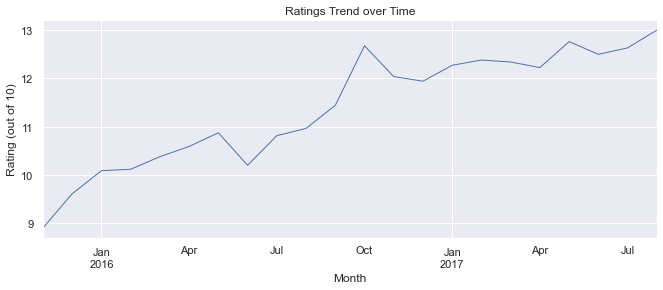

In [102]:
# Plot our average rating by month over time
ax = df_ratings.resample('M', on='timestamp').mean()['rating'].plot(title='Ratings Trend over Time', linewidth=1);
ax.set_xlabel("Month")
ax.set_ylabel("Rating (out of 10)")

Here we can clearly see that our average ratings have increased over time. From the time our dataset begins in late 2015, the average rating was below 10. When we finish in July of 2017, it has increased to 13. Our rater may have become more generous over time, but we'd need more evidence to prove this definitively. For example, did tweet content change over time, justifying a higher rating, etc.

#### Question (3): Do certain dog breeds have higher ratings?

Which predicted dog breeds get higher ratings on average? Are there any conclusions might we be able to draw from this?

To simplify our analysis, let's look only at tweets where a dog was the first predicted image and where the confidence is atleast 0.5 (50%).

In [103]:
# Create new set of tweets with 1st prediction is a dog with at least 50% confidence
df_predicted_dogs = df_archive_final[(df_archive_final['p1_dog'] == True) & (df_archive_final['p1_conf'] >= 0.5)]

# Double check the size of our set
print('The size of our set is: {}'.format(df_predicted_dogs['tweet_id'].count()))

# Normalize our ratings to be on a scale of 10
df_predicted_dogs['rating']= (df_predicted_dogs['rating_numerator']/df_predicted_dogs['rating_denominator'] * 10).astype(int)

# Keep only columns relevant for our analysis
df_predicted_dogs = df_predicted_dogs[['tweet_id','p1', 'rating']]

# Print first few records
df_predicted_dogs.head()

The size of our set is: 928


<ipython-input-103-54ba5b635bfa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predicted_dogs['rating']= (df_predicted_dogs['rating_numerator']/df_predicted_dogs['rating_denominator'] * 10).astype(int)


,tweet_id,p1,rating
0,667435689202614272,rottweiler,12
3,667453023279554560,labrador retriever,11
4,667455448082227200,tibetan terrier,7
6,667491009379606528,borzoi,7
8,667502640335572993,labrador retriever,11


Now, let's get a list of our highest rated dogs by breed on average.

In [104]:
df_predicted_dogs.groupby('p1').rating.mean().sort_values(ascending=False)

p1
clumber                   27.0
afghan hound              13.0
saluki                    13.0
curly-coated retriever    13.0
briard                    12.5
                          ... 
boston bull               8.4 
walker hound              8.0 
tibetan terrier           7.0 
japanese spaniel          5.0 
miniature schnauzer       5.0 
Name: rating, Length: 99, dtype: float64

Let's plot our findings for the top 10 highest rated breeds.

Text(0.5, 0, 'Ave. Rating')

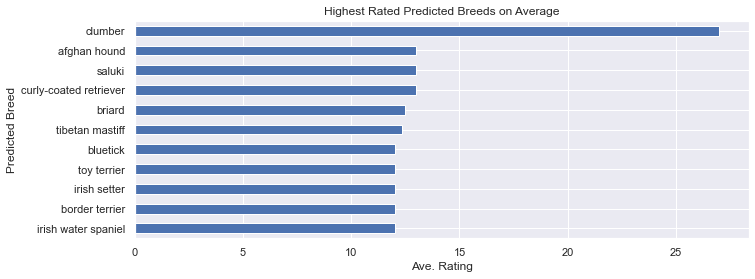

In [105]:
# Plot the top results of average rating by predicted dog breed.
ax = df_predicted_dogs.groupby('p1').rating.mean().sort_values(ascending=False)[10::-1].plot(kind='barh', title='Highest Rated Predicted Breeds on Average');
ax.set_ylabel("Predicted Breed")
ax.set_xlabel("Ave. Rating")

Our top result is very interesting, as it has a much higher average rating compared to the other breeds. Let's check to see how many 'clumbers' we have in this dataset.

In [106]:
print('# of clumbers: {}'.format(df_predicted_dogs[df_predicted_dogs['p1'] == 'clumber']['tweet_id'].count()))

# of clumbers: 1


There's only 1. Let's check the counts in our set of the top ten breeds with highest average ratings listed above.

In [107]:
# Get a list of the top ten breeds with highest average ratings
top_rated_breeds = df_predicted_dogs.groupby('p1').rating.mean().sort_values(ascending=False)[0:10].index.tolist()

# Print the total number of this type of breed in our set
for breed in top_rated_breeds:
    print('# of {}s: {}'.format(breed, df_predicted_dogs[df_predicted_dogs['p1'] == breed]['tweet_id'].count()))

# of clumbers: 1
# of afghan hounds: 1
# of salukis: 3
# of curly-coated retrievers: 1
# of briards: 2
# of tibetan mastiffs: 3
# of blueticks: 1
# of toy terriers: 1
# of irish setters: 2
# of border terriers: 3


These counts aren't very high considering that there are almost a thousand dogs in our set. We've stumbled upon something interesting. Most of these breeds are not among the most well known, at least not in North America, and they are not predicted very frequently. Let's check our value counts for breed predictions to get a better sense of which breeds are predicted most frequently.

In [108]:
df_predicted_dogs['p1'].value_counts()

golden retriever       115
pembroke               70 
labrador retriever     64 
chihuahua              46 
pug                    43 
                       .. 
giant schnauzer        1  
ibizan hound           1  
rhodesian ridgeback    1  
miniature schnauzer    1  
mexican hairless       1  
Name: p1, Length: 99, dtype: int64

This shows us that there are actually more predictions for more common, well-known breeds such as "golden retriever." Let's look at the average ratings for the top 10 predicted breeds.

In [109]:
# Get a list of the top ten predicted breeds
top_predicted_breeds = df_predicted_dogs['p1'].value_counts()[0:10].index.tolist()

# Create a dataframe of these breeds and their ratings
df_common_breeds_ratings = df_predicted_dogs[df_predicted_dogs['p1'].isin(top_predicted_breeds)]

# Print the ratings for the top 10 predicted breeds in descending order
df_common_breeds_ratings.groupby('p1').rating.mean().sort_values(ascending=False)

p1
samoyed               11.733333
chow                  11.730769
pembroke              11.657143
golden retriever      11.556522
french bulldog        11.227273
labrador retriever    11.218750
pomeranian            11.172414
toy poodle            11.130435
chihuahua             10.565217
pug                   10.209302
Name: rating, dtype: float64

Text(0.5, 0, 'Ave. Rating')

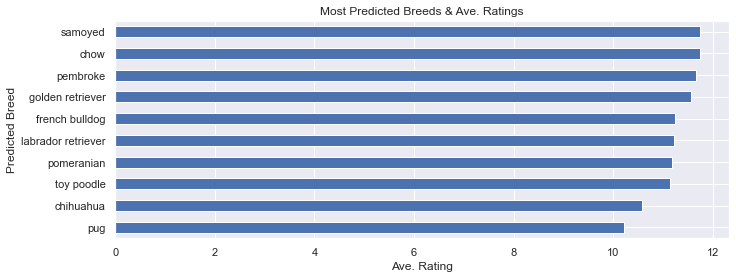

In [110]:
# Plot the most predicted breeds and their average ratings
ax = df_common_breeds_ratings.groupby('p1').rating.mean().sort_values(ascending=False)[10::-1].plot(kind='barh', title='Most Predicted Breeds & Ave. Ratings');
ax.set_ylabel("Predicted Breed")
ax.set_xlabel("Ave. Rating")

It appears that rarer, less predicted breeds are rated higher on average that more well-known and more frequently predicted breeds.

While we might be tempted to think that our rater has a preference for more exotic dog breeds, we'd need more evidence before coming to this conclusion definitively. Also, we must remember that we are dealing with image predictions, which may or may not be correct in reflecting the actual breed of the dog in the tweeted photos.

#### Question (4): Based on retweets and favorites, what dog breeds are the most popular?

Retweeting and favoriting a tweet are generally signs of approval on Twitter. Based on this, what dog breeds seem more "popular" in our set of tweets?

Let's create a new dataframe with the information that we'll need. Again, we're going to limit our set to those tweets for which the first image prediction is for a dog with confidence of greater than 50%. Also, to keep things simple, we're going to assume that popularity, as far as Twitter is concerned can calculated by summing the retweet and favorite count for a given tweet.

In [111]:
# Create new set of tweets with 1st prediction is a dog with at least 50% confidence
df_popular_dogs = df_archive_final[(df_archive_final['p1_dog'] == True) & (df_archive_final['p1_conf'] >= 0.5)]

# Double check the size of our set
print('The size of our set is: {}'.format(df_popular_dogs['tweet_id'].count()))

# If popularity can be measured by retweets and favorites, let's some these and create a new column
df_popular_dogs['popularity'] = df_popular_dogs['retweet_count'] + df_popular_dogs['favorite_count']

# Keep only columns relevant for our analysis
df_popular_dogs = df_popular_dogs[['tweet_id','p1', 'popularity', 'retweet_count', 'favorite_count']]

# Print first few records
df_popular_dogs.head()

The size of our set is: 928


<ipython-input-111-9e4a97e732bd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular_dogs['popularity'] = df_popular_dogs['retweet_count'] + df_popular_dogs['favorite_count']


,tweet_id,p1,popularity,retweet_count,favorite_count
0,667435689202614272,rottweiler,415,89,326
3,667453023279554560,labrador retriever,423,96,327
4,667455448082227200,tibetan terrier,269,66,203
6,667491009379606528,borzoi,801,242,559
8,667502640335572993,labrador retriever,794,231,563


Now, let's examine which predicted breeds have the highest popularity based on the average of the sum of retweet and favorite counts.

In [112]:
df_popular_dogs.groupby('p1').popularity.mean().sort_values(ascending=False)

p1
saluki                 37440.000000
irish water spaniel    31264.000000
eskimo dog             24974.555556
french bulldog         23033.318182
afghan hound           22617.000000
                           ...     
miniature schnauzer    1112.000000 
english springer       1068.000000 
redbone                836.000000  
giant schnauzer        332.000000  
tibetan terrier        269.000000  
Name: popularity, Length: 99, dtype: float64

Text(0.5, 0, '# of Retweets & Favorites')

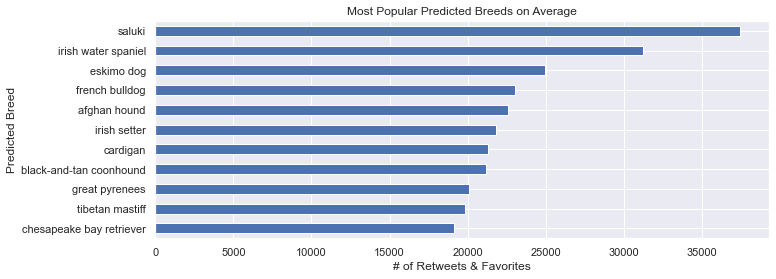

In [113]:
# Plot the top results of average popularity by predicted dog breeds
ax = df_popular_dogs.groupby('p1').popularity.mean().sort_values(ascending=False)[10::-1].plot(kind='barh', title='Most Popular Predicted Breeds on Average');
ax.set_ylabel("Predicted Breed")
ax.set_xlabel("# of Retweets & Favorites")

This time it appears that our top results are a mix of exotic, less frequently predicted breeds, as well as well-known, more frequently predicted breeds. Salukis appear to be the most popular with WeRateDogs Twitter followers, followed by irish water spaniels, eskimo dogs and french bulldogs.

Again, keep in mind that we're basing our analysis on predictions of the dog breeds from image analysis and we cannot be certain that these predictions are perfect match with the actual dogs in the tweeted photos.

<a id='concl'></a>
## Conclusion

In this project we completed the following:

1. Gathering the necessary data to explore the WeRateDogs twitter account including:
    - a file of the tweet arhive data with tweet text and dog ratings
    - a file of image predictions based upon the photos tweeted 
    - retweet and favorites counts gathered using the Twitter API
2. Assessed the quality of the above data, identifying quality and tidiness issues
3. Cleaned the above data based on the issues identified during the assessment
4. Analyzed the data to identify interesting insights, creating visualizations as necessary.

#### Reporting for this Project

Additional information is avaiable in the following files located in the same directory as this notebook:

- wrangle_report.pdf: Briefly describes the wrangling efforts (300-600 words)
- act_report.pdf: Communicates the insights and displays the visualization(s) produced from the wrangled data (250-word-minimum)
